In [132]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math
import time

saved_model_file = "./model.ckpt"

In [133]:
def plot_train(batches, loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

In [144]:
#features_count: all the pixels in the image 28*28
#labels: 0 to 9, total 10 labels
def train_model(X_train, y_train, X_valid, y_valid,
                learning_rate=0.2, n_input=784, n_classes=10,
                batch_size = 128, n_epochs = 100):
    # Remove previous Tensors and Operations
    tf.reset_default_graph()

    # Features and Labels
    features = tf.placeholder(tf.float32, [None, n_input], name="features")
    labels = tf.placeholder(tf.float32, [None, n_classes], name="labels")

    # Weights & bias
    W1 = tf.Variable(tf.truncated_normal((n_input, 32)), name="W1")
    b1 = tf.Variable(tf.zeros(32), name="b1")
    W2 = tf.Variable(tf.truncated_normal((32, n_classes)), name="W2")
    b2 = tf.Variable(tf.zeros(n_classes), name="b2")

    # Logits - xW + b
    hidden_layer = tf.add(tf.matmul(features, W1), b1)
    hidden_layer = tf.nn.relu(hidden_layer)
    #hidden_layer = tf.nn.dropout(hidden_layer, 0.8)#keep_prob
    logits = tf.add(tf.matmul(hidden_layer, W2), b2)
    prediction = tf.nn.softmax(logits, name="prediction")

    # Define loss and optimizer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

    # Calculate accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")
    
    batches = []
    loss_batch = []
    train_acc_batch = []
    valid_acc_batch = []

    validation_accuracy = 0.0
    log_batch_step=50
    saver = tf.train.Saver()
    
    config = tf.ConfigProto(device_count={'gpu':0})  
    #config = tf.ConfigProto()  
    #config.gpu_options.allow_growth=True 
    start_time = time.time()
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        total_batch = math.ceil(len(X_train) / batch_size)
        
        # Training cycle
        for epoch in range(n_epochs):
            # Loop over all batches
            for i in range(total_batch):
                # Get a batch of training features and labels
                batch_start = i*batch_size
                batch_features = X_train[batch_start:batch_start + batch_size]
                batch_labels = y_train[batch_start:batch_start + batch_size]
                sess.run(
                    optimizer,
                    feed_dict={features: batch_features, labels: batch_labels})

                # Run optimizer and get loss
                _, l = sess.run(
                    [optimizer, loss],
                    feed_dict={features: batch_features, labels: batch_labels})

                # Log every 50 batches
                if not i % log_batch_step:
                    # Calculate Training and Validation accuracy
                    training_accuracy = sess.run(accuracy, feed_dict={features:X_train, labels:y_train})
                    validation_accuracy = sess.run(accuracy, feed_dict={features:X_valid, labels:y_valid})
                    # Log batches
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_batch_step + previous_batch)
                    loss_batch.append(l)
                    train_acc_batch.append(training_accuracy)
                    valid_acc_batch.append(validation_accuracy)
                print("epoch {} batch {}:loss {}. training_accuracy {}, validation_accuracy {}."
                          .format(epoch, i, l, training_accuracy, validation_accuracy))
                    
        # Check accuracy against Validation data
        validation_accuracy = sess.run(accuracy, feed_dict={features:X_valid, labels:y_valid})
        # Save the model
        saver.save(sess, saved_model_file)
        print('Trained Model Saved.')
        
    end_time = time.time()
    print("model trained in {} seconds".format(end_time-start_time))
    print("training process done, validation accuracy is:{}".format(validation_accuracy))
    plot_train(batches, loss_batch, train_acc_batch, valid_acc_batch)

In [145]:
def predict_data(X):
    meta_path =saved_model_file + ".meta" 
    saver = tf.train.import_meta_graph(meta_path) # 导入图  
     
    config = tf.ConfigProto()  
    config.gpu_options.allow_growth=True 
    prediction = []
    with tf.Session(config=config) as sess:  
        saver.restore(sess, saved_model_file) # 导入变量值  
        graph = tf.get_default_graph() 
        features = graph.get_tensor_by_name("features:0")
        predictor = graph.get_tensor_by_name("prediction:0") 
        prediction = sess.run(predictor, feed_dict={features:X})
    return prediction

In [146]:
def show_image(image_data):
    plt.figure()
    plt.imshow(image_data)
    plt.show()

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
load data done.


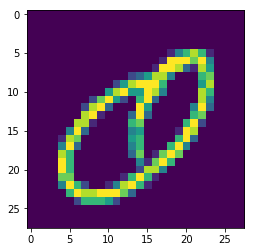

epoch 0 batch 0:loss 27.12903594970703. training_accuracy 0.16038182377815247, validation_accuracy 0.1728000044822693.
epoch 0 batch 1:loss 15.462596893310547. training_accuracy 0.16038182377815247, validation_accuracy 0.1728000044822693.
epoch 0 batch 2:loss 8.969108581542969. training_accuracy 0.16038182377815247, validation_accuracy 0.1728000044822693.
epoch 0 batch 3:loss 6.310593128204346. training_accuracy 0.16038182377815247, validation_accuracy 0.1728000044822693.
epoch 0 batch 4:loss 5.60170841217041. training_accuracy 0.16038182377815247, validation_accuracy 0.1728000044822693.
epoch 0 batch 5:loss 4.207912445068359. training_accuracy 0.16038182377815247, validation_accuracy 0.1728000044822693.
epoch 0 batch 6:loss 3.993460178375244. training_accuracy 0.16038182377815247, validation_accuracy 0.1728000044822693.
epoch 0 batch 7:loss 3.3889312744140625. training_accuracy 0.16038182377815247, validation_accuracy 0.1728000044822693.
epoch 0 batch 8:loss 3.291375160217285. trainin

epoch 0 batch 100:loss 0.9990031719207764. training_accuracy 0.7041272521018982, validation_accuracy 0.7196000218391418.
epoch 0 batch 101:loss 0.6419115662574768. training_accuracy 0.7041272521018982, validation_accuracy 0.7196000218391418.
epoch 0 batch 102:loss 0.6958657503128052. training_accuracy 0.7041272521018982, validation_accuracy 0.7196000218391418.
epoch 0 batch 103:loss 0.5847201347351074. training_accuracy 0.7041272521018982, validation_accuracy 0.7196000218391418.
epoch 0 batch 104:loss 0.8488591909408569. training_accuracy 0.7041272521018982, validation_accuracy 0.7196000218391418.
epoch 0 batch 105:loss 0.8051189184188843. training_accuracy 0.7041272521018982, validation_accuracy 0.7196000218391418.
epoch 0 batch 106:loss 1.1431355476379395. training_accuracy 0.7041272521018982, validation_accuracy 0.7196000218391418.
epoch 0 batch 107:loss 0.849138081073761. training_accuracy 0.7041272521018982, validation_accuracy 0.7196000218391418.
epoch 0 batch 108:loss 0.61268275

epoch 0 batch 200:loss 0.8437519073486328. training_accuracy 0.7565818428993225, validation_accuracy 0.7612000107765198.
epoch 0 batch 201:loss 0.7539293169975281. training_accuracy 0.7565818428993225, validation_accuracy 0.7612000107765198.
epoch 0 batch 202:loss 1.0349304676055908. training_accuracy 0.7565818428993225, validation_accuracy 0.7612000107765198.
epoch 0 batch 203:loss 0.5769350528717041. training_accuracy 0.7565818428993225, validation_accuracy 0.7612000107765198.
epoch 0 batch 204:loss 0.7756515145301819. training_accuracy 0.7565818428993225, validation_accuracy 0.7612000107765198.
epoch 0 batch 205:loss 0.9832690954208374. training_accuracy 0.7565818428993225, validation_accuracy 0.7612000107765198.
epoch 0 batch 206:loss 0.6708354353904724. training_accuracy 0.7565818428993225, validation_accuracy 0.7612000107765198.
epoch 0 batch 207:loss 0.5702111721038818. training_accuracy 0.7565818428993225, validation_accuracy 0.7612000107765198.
epoch 0 batch 208:loss 1.0046685

epoch 0 batch 300:loss 0.33801496028900146. training_accuracy 0.7900909185409546, validation_accuracy 0.7937999963760376.
epoch 0 batch 301:loss 0.4105861186981201. training_accuracy 0.7900909185409546, validation_accuracy 0.7937999963760376.
epoch 0 batch 302:loss 0.5485389232635498. training_accuracy 0.7900909185409546, validation_accuracy 0.7937999963760376.
epoch 0 batch 303:loss 0.9358735084533691. training_accuracy 0.7900909185409546, validation_accuracy 0.7937999963760376.
epoch 0 batch 304:loss 0.7503466010093689. training_accuracy 0.7900909185409546, validation_accuracy 0.7937999963760376.
epoch 0 batch 305:loss 0.6935117244720459. training_accuracy 0.7900909185409546, validation_accuracy 0.7937999963760376.
epoch 0 batch 306:loss 0.5851032733917236. training_accuracy 0.7900909185409546, validation_accuracy 0.7937999963760376.
epoch 0 batch 307:loss 0.6693252325057983. training_accuracy 0.7900909185409546, validation_accuracy 0.7937999963760376.
epoch 0 batch 308:loss 0.547628

epoch 0 batch 400:loss 0.639137327671051. training_accuracy 0.8099091053009033, validation_accuracy 0.8108000159263611.
epoch 0 batch 401:loss 0.4111594557762146. training_accuracy 0.8099091053009033, validation_accuracy 0.8108000159263611.
epoch 0 batch 402:loss 0.6130908727645874. training_accuracy 0.8099091053009033, validation_accuracy 0.8108000159263611.
epoch 0 batch 403:loss 0.4915223717689514. training_accuracy 0.8099091053009033, validation_accuracy 0.8108000159263611.
epoch 0 batch 404:loss 0.2808169424533844. training_accuracy 0.8099091053009033, validation_accuracy 0.8108000159263611.
epoch 0 batch 405:loss 0.2666277289390564. training_accuracy 0.8099091053009033, validation_accuracy 0.8108000159263611.
epoch 0 batch 406:loss 0.4472181499004364. training_accuracy 0.8099091053009033, validation_accuracy 0.8108000159263611.
epoch 0 batch 407:loss 0.1952822357416153. training_accuracy 0.8099091053009033, validation_accuracy 0.8108000159263611.
epoch 0 batch 408:loss 0.65376329

epoch 1 batch 50:loss 0.37064245343208313. training_accuracy 0.838345468044281, validation_accuracy 0.8396000266075134.
epoch 1 batch 51:loss 0.5576146841049194. training_accuracy 0.838345468044281, validation_accuracy 0.8396000266075134.
epoch 1 batch 52:loss 0.5308523178100586. training_accuracy 0.838345468044281, validation_accuracy 0.8396000266075134.
epoch 1 batch 53:loss 0.3509255051612854. training_accuracy 0.838345468044281, validation_accuracy 0.8396000266075134.
epoch 1 batch 54:loss 0.531752347946167. training_accuracy 0.838345468044281, validation_accuracy 0.8396000266075134.
epoch 1 batch 55:loss 0.37897881865501404. training_accuracy 0.838345468044281, validation_accuracy 0.8396000266075134.
epoch 1 batch 56:loss 0.46942391991615295. training_accuracy 0.838345468044281, validation_accuracy 0.8396000266075134.
epoch 1 batch 57:loss 0.37796854972839355. training_accuracy 0.838345468044281, validation_accuracy 0.8396000266075134.
epoch 1 batch 58:loss 0.5446534752845764. tra

epoch 1 batch 150:loss 0.449544221162796. training_accuracy 0.8450000286102295, validation_accuracy 0.8435999751091003.
epoch 1 batch 151:loss 0.2520594894886017. training_accuracy 0.8450000286102295, validation_accuracy 0.8435999751091003.
epoch 1 batch 152:loss 0.5883547067642212. training_accuracy 0.8450000286102295, validation_accuracy 0.8435999751091003.
epoch 1 batch 153:loss 0.6663199067115784. training_accuracy 0.8450000286102295, validation_accuracy 0.8435999751091003.
epoch 1 batch 154:loss 0.6360872983932495. training_accuracy 0.8450000286102295, validation_accuracy 0.8435999751091003.
epoch 1 batch 155:loss 0.4508078396320343. training_accuracy 0.8450000286102295, validation_accuracy 0.8435999751091003.
epoch 1 batch 156:loss 0.2888208329677582. training_accuracy 0.8450000286102295, validation_accuracy 0.8435999751091003.
epoch 1 batch 157:loss 0.4070635139942169. training_accuracy 0.8450000286102295, validation_accuracy 0.8435999751091003.
epoch 1 batch 158:loss 0.44273912

epoch 1 batch 250:loss 0.4048357307910919. training_accuracy 0.8456545472145081, validation_accuracy 0.8489999771118164.
epoch 1 batch 251:loss 0.19508135318756104. training_accuracy 0.8456545472145081, validation_accuracy 0.8489999771118164.
epoch 1 batch 252:loss 0.6918983459472656. training_accuracy 0.8456545472145081, validation_accuracy 0.8489999771118164.
epoch 1 batch 253:loss 0.5336331725120544. training_accuracy 0.8456545472145081, validation_accuracy 0.8489999771118164.
epoch 1 batch 254:loss 0.5354834794998169. training_accuracy 0.8456545472145081, validation_accuracy 0.8489999771118164.
epoch 1 batch 255:loss 0.4197453558444977. training_accuracy 0.8456545472145081, validation_accuracy 0.8489999771118164.
epoch 1 batch 256:loss 0.42977970838546753. training_accuracy 0.8456545472145081, validation_accuracy 0.8489999771118164.
epoch 1 batch 257:loss 0.2967683970928192. training_accuracy 0.8456545472145081, validation_accuracy 0.8489999771118164.
epoch 1 batch 258:loss 0.26837

epoch 1 batch 350:loss 0.6966153979301453. training_accuracy 0.8294363617897034, validation_accuracy 0.8352000117301941.
epoch 1 batch 351:loss 0.3680550456047058. training_accuracy 0.8294363617897034, validation_accuracy 0.8352000117301941.
epoch 1 batch 352:loss 0.37750014662742615. training_accuracy 0.8294363617897034, validation_accuracy 0.8352000117301941.
epoch 1 batch 353:loss 0.4254705607891083. training_accuracy 0.8294363617897034, validation_accuracy 0.8352000117301941.
epoch 1 batch 354:loss 0.6930328011512756. training_accuracy 0.8294363617897034, validation_accuracy 0.8352000117301941.
epoch 1 batch 355:loss 0.34961146116256714. training_accuracy 0.8294363617897034, validation_accuracy 0.8352000117301941.
epoch 1 batch 356:loss 0.4376336932182312. training_accuracy 0.8294363617897034, validation_accuracy 0.8352000117301941.
epoch 1 batch 357:loss 0.36963388323783875. training_accuracy 0.8294363617897034, validation_accuracy 0.8352000117301941.
epoch 1 batch 358:loss 0.1763

epoch 2 batch 0:loss 0.38711827993392944. training_accuracy 0.8603454828262329, validation_accuracy 0.8628000020980835.
epoch 2 batch 1:loss 0.4686412513256073. training_accuracy 0.8603454828262329, validation_accuracy 0.8628000020980835.
epoch 2 batch 2:loss 0.4352013170719147. training_accuracy 0.8603454828262329, validation_accuracy 0.8628000020980835.
epoch 2 batch 3:loss 0.24291542172431946. training_accuracy 0.8603454828262329, validation_accuracy 0.8628000020980835.
epoch 2 batch 4:loss 0.3390277326107025. training_accuracy 0.8603454828262329, validation_accuracy 0.8628000020980835.
epoch 2 batch 5:loss 0.4354502558708191. training_accuracy 0.8603454828262329, validation_accuracy 0.8628000020980835.
epoch 2 batch 6:loss 0.305931031703949. training_accuracy 0.8603454828262329, validation_accuracy 0.8628000020980835.
epoch 2 batch 7:loss 0.22982047498226166. training_accuracy 0.8603454828262329, validation_accuracy 0.8628000020980835.
epoch 2 batch 8:loss 0.33138737082481384. trai

epoch 2 batch 94:loss 0.4343221187591553. training_accuracy 0.8704545497894287, validation_accuracy 0.8744000196456909.
epoch 2 batch 95:loss 0.351737380027771. training_accuracy 0.8704545497894287, validation_accuracy 0.8744000196456909.
epoch 2 batch 96:loss 0.32980865240097046. training_accuracy 0.8704545497894287, validation_accuracy 0.8744000196456909.
epoch 2 batch 97:loss 0.45716720819473267. training_accuracy 0.8704545497894287, validation_accuracy 0.8744000196456909.
epoch 2 batch 98:loss 0.4221896529197693. training_accuracy 0.8704545497894287, validation_accuracy 0.8744000196456909.
epoch 2 batch 99:loss 0.44656604528427124. training_accuracy 0.8704545497894287, validation_accuracy 0.8744000196456909.
epoch 2 batch 100:loss 0.39440733194351196. training_accuracy 0.860872745513916, validation_accuracy 0.8646000027656555.
epoch 2 batch 101:loss 0.24171008169651031. training_accuracy 0.860872745513916, validation_accuracy 0.8646000027656555.
epoch 2 batch 102:loss 0.24618488550

epoch 2 batch 194:loss 0.40578100085258484. training_accuracy 0.8722909092903137, validation_accuracy 0.871399998664856.
epoch 2 batch 195:loss 0.511813759803772. training_accuracy 0.8722909092903137, validation_accuracy 0.871399998664856.
epoch 2 batch 196:loss 0.5413260459899902. training_accuracy 0.8722909092903137, validation_accuracy 0.871399998664856.
epoch 2 batch 197:loss 0.41808032989501953. training_accuracy 0.8722909092903137, validation_accuracy 0.871399998664856.
epoch 2 batch 198:loss 0.2072136104106903. training_accuracy 0.8722909092903137, validation_accuracy 0.871399998664856.
epoch 2 batch 199:loss 0.3276263475418091. training_accuracy 0.8722909092903137, validation_accuracy 0.871399998664856.
epoch 2 batch 200:loss 0.4962877035140991. training_accuracy 0.8680363893508911, validation_accuracy 0.8722000122070312.
epoch 2 batch 201:loss 0.37588465213775635. training_accuracy 0.8680363893508911, validation_accuracy 0.8722000122070312.
epoch 2 batch 202:loss 0.40365177392

epoch 2 batch 300:loss 0.13722187280654907. training_accuracy 0.8740181922912598, validation_accuracy 0.8784000277519226.
epoch 2 batch 301:loss 0.2372908592224121. training_accuracy 0.8740181922912598, validation_accuracy 0.8784000277519226.
epoch 2 batch 302:loss 0.3909143805503845. training_accuracy 0.8740181922912598, validation_accuracy 0.8784000277519226.
epoch 2 batch 303:loss 0.46468600630760193. training_accuracy 0.8740181922912598, validation_accuracy 0.8784000277519226.
epoch 2 batch 304:loss 0.3535710871219635. training_accuracy 0.8740181922912598, validation_accuracy 0.8784000277519226.
epoch 2 batch 305:loss 0.43931514024734497. training_accuracy 0.8740181922912598, validation_accuracy 0.8784000277519226.
epoch 2 batch 306:loss 0.29484379291534424. training_accuracy 0.8740181922912598, validation_accuracy 0.8784000277519226.
epoch 2 batch 307:loss 0.34143051505088806. training_accuracy 0.8740181922912598, validation_accuracy 0.8784000277519226.
epoch 2 batch 308:loss 0.37

epoch 2 batch 396:loss 0.27080583572387695. training_accuracy 0.8488181829452515, validation_accuracy 0.8578000068664551.
epoch 2 batch 397:loss 0.17491814494132996. training_accuracy 0.8488181829452515, validation_accuracy 0.8578000068664551.
epoch 2 batch 398:loss 0.1829705536365509. training_accuracy 0.8488181829452515, validation_accuracy 0.8578000068664551.
epoch 2 batch 399:loss 0.21664777398109436. training_accuracy 0.8488181829452515, validation_accuracy 0.8578000068664551.
epoch 2 batch 400:loss 0.4350179433822632. training_accuracy 0.8691636323928833, validation_accuracy 0.8726000189781189.
epoch 2 batch 401:loss 0.2756791114807129. training_accuracy 0.8691636323928833, validation_accuracy 0.8726000189781189.
epoch 2 batch 402:loss 0.44960957765579224. training_accuracy 0.8691636323928833, validation_accuracy 0.8726000189781189.
epoch 2 batch 403:loss 0.32704731822013855. training_accuracy 0.8691636323928833, validation_accuracy 0.8726000189781189.
epoch 2 batch 404:loss 0.12

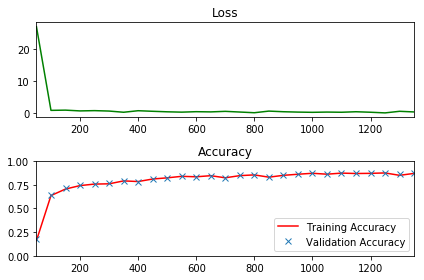

true label: 2, prediction: 2


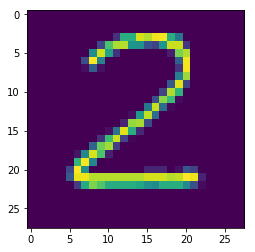

true label: 6, prediction: 6


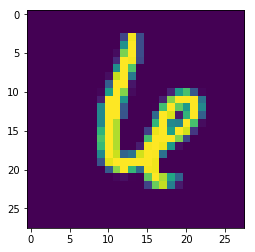

true label: 5, prediction: 5


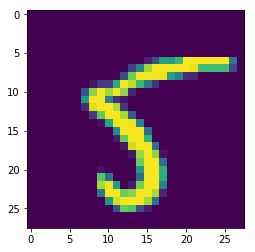

true label: 3, prediction: 3


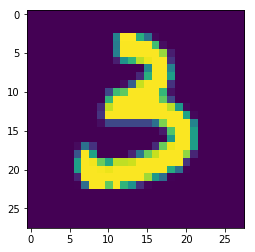

true label: 7, prediction: 7


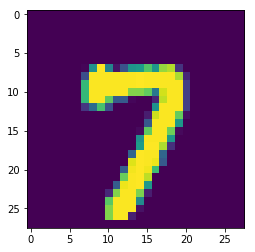

true label: 4, prediction: 4


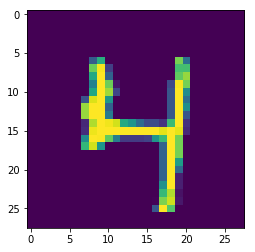

true label: 1, prediction: 1


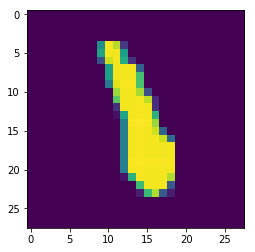

true label: 7, prediction: 7


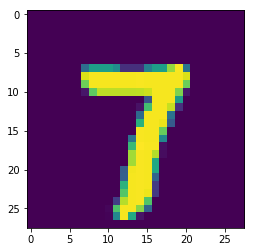

true label: 1, prediction: 1


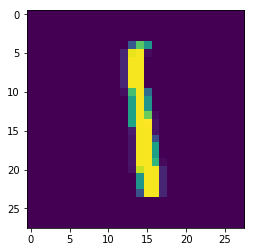

true label: 2, prediction: 2


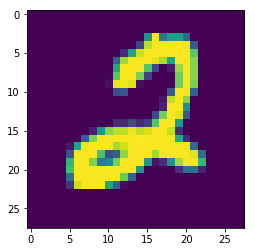

In [147]:
if __name__=="__main__":   
    old_v = tf.logging.get_verbosity()
    tf.logging.set_verbosity(tf.logging.ERROR)

    mnist = input_data.read_data_sets('.', one_hot=True)
    train_features = mnist.train.images
    train_labels = mnist.train.labels
    valid_features = mnist.validation.images
    valid_labels = mnist.validation.labels
    test_features = mnist.test.images
    test_labels = mnist.test.labels
    del mnist
    print("load data done.")
    

    #display one images
    test_idx = np.random.randint(len(train_features))
    test_image = train_features[test_idx].reshape((28,28))
    show_image(test_image)
    
    train_model(train_features,train_labels, valid_features, valid_labels, n_epochs=3)
    
    #test predict
    for i in range(10): # show 5 images
        test_idx = np.random.randint(len(test_features))
        test_image = test_features[test_idx]  
        print("true label: {}, prediction: {}".format(np.argmax(test_labels[test_idx]), np.argmax(predict_data([test_image]))))
        show_image(test_image.reshape(28,28))
        
    tf.logging.set_verbosity(old_v)